## Analysis of University Course Descriptions using NLP

### Motivation and Objective

Nowadays most technology universities offer a wide variety of cyberseccurity courses, but their descriptions are often inconsistent or unclear. This project's purpose to analyze and process course descriptions using **Natural Language Processing** techniques to uncover hidden patterns, improve similarity analysis, and prepare the ground for job market comparision.


### The Dataset

The dataset consists of course titles and descriptions obtained from multiple sources and stored in an Excel file (`dataset.xlsx`). Each row corresponds to a single course, with descriptive and informative fields like: 'university_name', 'study_program_name', 'city', 'country' and 'description'.


### Necessary Imports
All necessary packages for this notebook are imported below.


These include libraries for data handling (Pandas, NumPy), visualization (Matplotlib, Seaborn), text processing (re, NLTK, spaCy), and machine learning (Scikit-learn).


In [1]:
# Import essential libraries for data manipulation, visualization, and NLP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import itertools
from wordcloud import WordCloud

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy import displacy

import zipfile

In [2]:
# Download necessary NLTK datasets for tokenization and stopwords\n",

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Load Dataset
The dataset is stored in Google Drive. To access it within this Google Colab notebook, we need to mount the Google Drive, which makes its files accessible as if they were local files.

In [3]:
# Mount Google Drive to access files stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Read the Dataset
Now that Google Drive is mounted, we use the Pandas library to read the `dataset.xlsx` file into a DataFrame. We then display basic information about the DataFrame (like column names, data types, and non-null counts) and show the first few rows to get an initial look at the data.

In [4]:
df = pd.read_excel('/content/drive/MyDrive/dslab/dataset.xlsx')

# Display basic information about the dataset
print("Dataset overview:")
df.info()
df.head()

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2 non-null      object
 1   university_name     143 non-null    object
 2   study_program_name  143 non-null    object
 3   city                143 non-null    object
 4   country             143 non-null    object
 5   year_established    143 non-null    int64 
 6   description         143 non-null    object
dtypes: int64(1), object(6)
memory usage: 7.9+ KB


,id,university_name,study_program_name,city,country,year_established,description
0,iva_rtu_security,Riga Technical University,Cybersecurity Engineering,Riga,lva,2021,"Brand new study program, with focus on industr..."
1,deu_hn_security,Hochschule Niederrhein,Cyber Security Management,Mönchengladbach,deu,2020,The study concept offers problem-based learnin...
2,NaN,University of Oulu,Cybersecurity specialisation for Computer Scie...,Oulu,fin,2023,The student specialising in cybersecurity will...
3,NaN,European University Cyprus,MSc in Cybersecurity,Nicosia,cyp,2017,The MSc in Cybersecurity at EUC addresses the ...
4,NaN,Escuela Internacional de Criminología y Crimin...,High Specialization Master in Forensic Computi...,San Juan de Alicante,esp,2006,This master offers the student a complete trai...


### Data Exploration
Before processing the text, it's crucial to understand the dataset's characteristics. We start by checking for missing values, as these can cause issues in later analysis steps.

In [5]:
# Check for the missing values in each column
print("Missing values:")
print(df.isnull().sum())

Missing values:
id                    141
university_name         0
study_program_name      0
city                    0
country                 0
year_established        0
description             0
dtype: int64


#### Check for Duplicates
Duplicate entries can skew analysis results. We check for duplicate course titles and descriptions separately.

In [6]:
# Check for duplicates course ritles
duplicate_titles = df['study_program_name'].duplicated().sum()
print("Duplicate course titles:", duplicate_titles)

# Check for and count duplicate course descriptions
duplicate_descriptions = df['description'].duplicated().sum()
print("\nDuplicate course descriptions:", duplicate_descriptions)

Duplicate course titles: 27

Duplicate course descriptions: 0


No missing values in the course titles and descriptions.

But there are a quite a few duplicates in the course titles. We should investigate if these titles with duplicate names also have different descriptions.

In [7]:
# Identify courses with duplicate titles
duplicate_courses = df[df.duplicated(subset=['study_program_name'], keep=False)]

# Count how many unique descriptions each duplicate title has
unique_descriptions_per_title = duplicate_courses.groupby('study_program_name')['description'].nunique()

# Filter to find titles that have more than one unique description
titles_with_different_descriptions = unique_descriptions_per_title[unique_descriptions_per_title > 1]

# Display the count and the list of such title
print(f"Number of course titles with different descriptions: {len(titles_with_different_descriptions)}")
print(titles_with_different_descriptions)

Number of course titles with different descriptions: 11
study_program_name
Cyber Security                          2
Cyber Security Management               2
Cybersecurity                          11
Cybersecurity Engineering               2
Cybersecurity and Digital Forensics     2
IT Security                             2
Information Security                    5
MSc Cybersecurity                       2
MSc in Cybersecurity                    3
Master in Cybersecurity                 5
Master of Science in Cybersecurity      2
Name: description, dtype: int64


These courses have multiple descriptions. This could indicate different versions of the same course or perhaps courses with the same name at different institutions.

For now, we'll keep them but be mindful of this during similarity analysis.

#### Analyze Text Lengths
Understanding the length (in terms of word count) of titles and descriptions gives us a sense of their verbosity and can help inform preprocessing choices or model selection.

We calculate descriptive statistics (mean, min, max, quartiles) for both.

In [9]:
# Calculate the length (word count) of each course title
print("Course title lengths information:")
df['title_length'] = df['study_program_name'].apply(lambda x: len(str(x).split()))
print(df['title_length'].describe())

# Calculate the length (word count) of each course description
print("\nCourse description lengths information:")
df['desc_length'] = df['description'].apply(lambda x: len(str(x).split()))
print(df['desc_length'].describe())

# Display the 10 courses with the longest descriptions
print("\nTop 10 longest course descriptions:")
print(df.nlargest(10, 'desc_length')[['study_program_name', 'desc_length']])

Course title lengths information:
count    143.000000
mean       4.629371
std        2.610052
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       13.000000
Name: title_length, dtype: float64

Course description lengths information:
count    143.000000
mean      72.776224
std       23.672478
min       11.000000
25%       59.500000
50%       73.000000
75%       88.000000
max      115.000000
Name: desc_length, dtype: float64

Top 10 longest course descriptions:
                                    study_program_name  desc_length
14                      Master Degree in Cybersecurity          115
107  Master of High Specialization in Cybersecurity...          113
138  Computer Engineering and Science for Cybersecu...          113
142  CyberMACS- Erasmus Mundus Joint Master’s Degre...          113
61                      Applied Electrical Engineering          112
111  Master's Degree in Cybersecurity and Data Inte...          112
131                    

**Insights on titles**
- Titles have an average of 4.62 words (min: 1, max: 11)
- 50% of the titles are 4 words or fewer

**Insights on descriptions**
- Average description length: 72.77 words
- Shortest description: 11 words
- Longest: 115 words
- 50% of descriptions are 73 words or fewer

#### Visualize Text Lengths
Histograms and Kernel Density Estimate (KDE) plots help visualize the distribution of title and description lengths. This gives a clearer picture than just statistics, showing where most lengths fall and identifying any outliers.

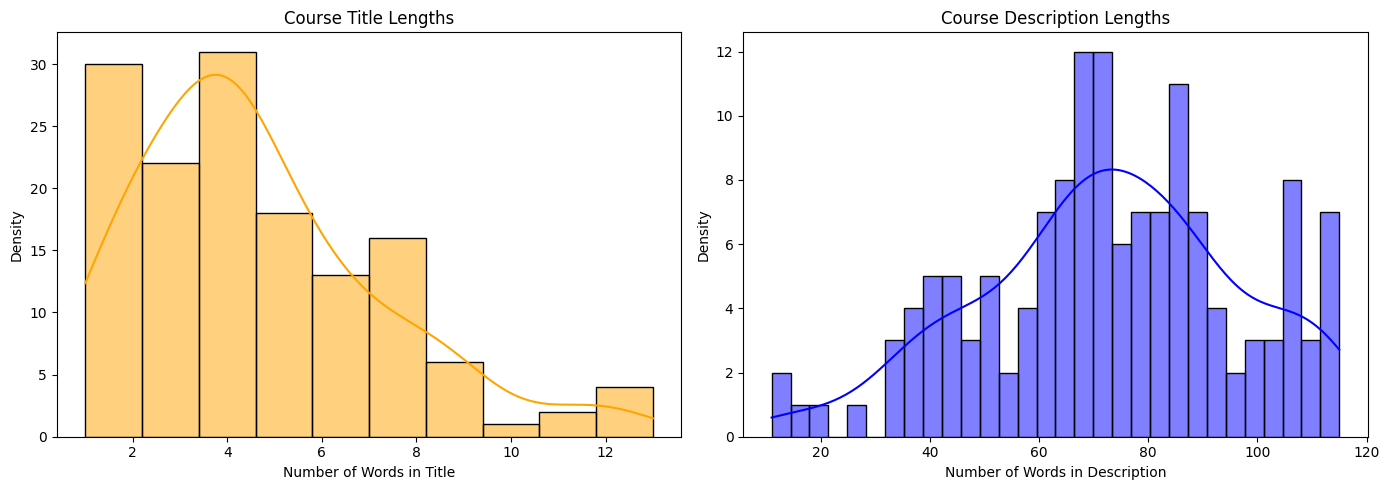

In [10]:
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot a histogram with a Kernel Density Estimate (KDE) for Course Title Lengths
sns.histplot(df['title_length'], bins=10, kde=True, color="orange", ax=axes[0])
axes[0].set_xlabel("Number of Words in Title")
axes[0].set_ylabel("Density")
axes[0].set_title("Course Title Lengths")

# Plot a histogram with KDE for Course Description Lengths
sns.histplot(df['desc_length'], bins=30, kde=True, color="blue", ax=axes[1])
axes[1].set_xlabel("Number of Words in Description")
axes[1].set_ylabel("Density")
axes[1].set_title("Course Description Lengths")

# Adjust subplot layout to prevent overlap
plt.tight_layout()
plt.show()

**Course titles:**
- Most course titles contain around 2 to 6 words, as indicated by the peak
- Very short (1 word) or very long (8+ words) titles are less common

**Course descriptions:**
- Most course descriptions fall in the range of 30 to 110 words
- The distribution is right-skewed, meaning some descriptions are very long (100+ words)


Both distributions are right-skewed, meaning a few courses have significantly longer titles or descriptions than the majority

#### Language Detection
Since many NLP tools, especially for NER and specific embeddings, work best with English text, we need to verify the language of the descriptions. We use the `langdetect` library for this purpose.

In [11]:
# Install the langdetect library for language identification
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=59feea591396c76db702c50931de1985e46cf282fc075d1f185668583097061f
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [12]:
# Import the detect function from langdetect
# Because NER does not perform well on non-english texts
from langdetect import detect

# Apply language detection to each non-null description and store the results in a new column
df["language"] = df['description'].dropna().apply(lambda x: detect(x))
print(df["language"].value_counts())

language
en    143
Name: count, dtype: int64


## Word frequency analysis and Text Preprocessing

To analyze the content effectively, we need to clean and standardize the text data. This involves several steps:

- **Lowercasing:** Converting all text to lowercase to treat words like 'Security' and 'security' as the same.

- **Removing Punctuation:** Eliminating characters that aren't letters or spaces.

- **Tokenizing:** Splitting the text into individual words or tokens.

- **Removing Stopwords:** Filtering out common words that usually don't carry much meaning (e.g., 'a', 'the', 'is').

- **Lemmatizing:** Reducing words to their base or dictionary form (e.g., 'running' to 'run').

After preprocessing, we will calculate word frequencies and visualize them.


In [13]:
# Load the set of English stopwords from NLTK
stop_words = set(stopwords.words('english'))

#### Preprocessing Function
We define a function `preprocess_text` that encapsulates the cleaning steps (lowercasing, punctuation removal, tokenization, stopword removal).

In [14]:
# Define a function to preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

#### Apply Preprocessing
We apply the `preprocess_text` function to both the 'description' and 'study_program_name' columns, storing the resulting lists of tokens in new columns.

In [15]:
# Apply the preprocessing function to course descriptions
df['desc_tokens'] = df['description'].apply(preprocess_text)

# Display the first few tokenized descriptions
df['desc_tokens'].head()

,desc_tokens
0,"[brand, new, study, program, focus, industrial..."
1,"[study, concept, offers, problembased, learnin..."
2,"[student, specialising, cybersecurity, able, d..."
3,"[msc, cybersecurity, euc, addresses, increasin..."
4,"[master, offers, student, complete, training, ..."


In [16]:
# Apply the preprocessing function to course titles too and display the first few
df['title_tokens'] = df['study_program_name'].apply(preprocess_text)
df['title_tokens'].head()

,title_tokens
0,"[cybersecurity, engineering]"
1,"[cyber, security, management]"
2,"[cybersecurity, specialisation, computer, scie..."
3,"[msc, cybersecurity]"
4,"[high, specialization, master, forensic, compu..."


#### Word Frequency Analysis
To understand the key themes, we identify the most frequently occurring words. We define a function `get_most_frequent_words` to count words and return the top N.

In [17]:
# Define a function to get the most frequent words from a tokenized column
def get_most_frequent_words(df, column_name, num_words):
    all_words = [word for tokens in df[column_name] for word in tokens] # Combine all tokens into a single list
    word_freq = Counter(all_words) # Count the frequency of each word
    common_words = word_freq.most_common(num_words)  # Get the most common words

    print(f"Most Common Words in {column_name}:")
    for word, freq in common_words:
        print(f"{word}: {freq}")

    return common_words

In [18]:
#  Get the 10 most frequent words from titles
common_words_title = get_most_frequent_words(df, column_name='title_tokens', num_words=10)
print('\n')

# Get the 20 most frequent words from descriptions
common_words_desc = get_most_frequent_words(df, column_name='desc_tokens', num_words=20)

Most Common Words in title_tokens:
cybersecurity: 68
security: 58
master: 35
information: 28
cyber: 18
engineering: 16
computer: 16
management: 14
degree: 14
systems: 14


Most Common Words in desc_tokens:
cybersecurity: 345
security: 219
skills: 124
information: 113
cyber: 101
european: 91
ecsf: 89
framework: 86
roles: 80
defined: 77
possible: 71
career: 70
systems: 70
paths: 67
programme: 60
program: 49
students: 49
management: 48
digital: 45
officer: 45


- With 89 occurrences, "cybersecurity" is the most frequently used word in course titles, indicating a heavy emphasis on security-related subjects

- Frequently used terms that emphasize information security, system management, and cybersecurity are "security" (68), "master" (54), "information" (53), and "cyber" (48)

- Additionally, "engineering" (44) appears frequently, suggesting a subset of courses pertaining to secure a engineer approach to their programmes

- The frequency of "Advanced" (41) suggests many courses are designed for intermediate or expert students

- Words such as "data" (39), "software" (36), and "computer" (34) suggest a more general emphasis on subjects pertaining to technology

- The word "security" appears 1,973 times that indicates that security is a key topic in all of the courses

- According to the terms "course" (1350) and "students" (1044), a lot of descriptions highlight the benefits that students will experience

- "Data" (849) and "Systems" (1243) further emphasize the technical and infrastructure-related focus of these courses

- The terms "knowledge" (778), "able" (694), and "learning" (627) show that skill-building and student capabilities are commonly mentioned in descriptions

- Words that imply a focus on networking topics include "network" (510) and "networks" (499)

- Many courses teach practical approaches to problem-solving, as evidenced by terms like "methods" (474), "system" (471), "software" (464), and "techniques" (437)


#### Visualize Word Frequencies
Bar plots provide a clear visual comparison of the frequencies of the most common words in both titles and descriptions.

<ipython-input-19-c1cf66cb8f4f>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-19-c1cf66cb8f4f>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


Text(0.5, 1.0, 'Top 20 Most Frequent Words in Course Descriptions')

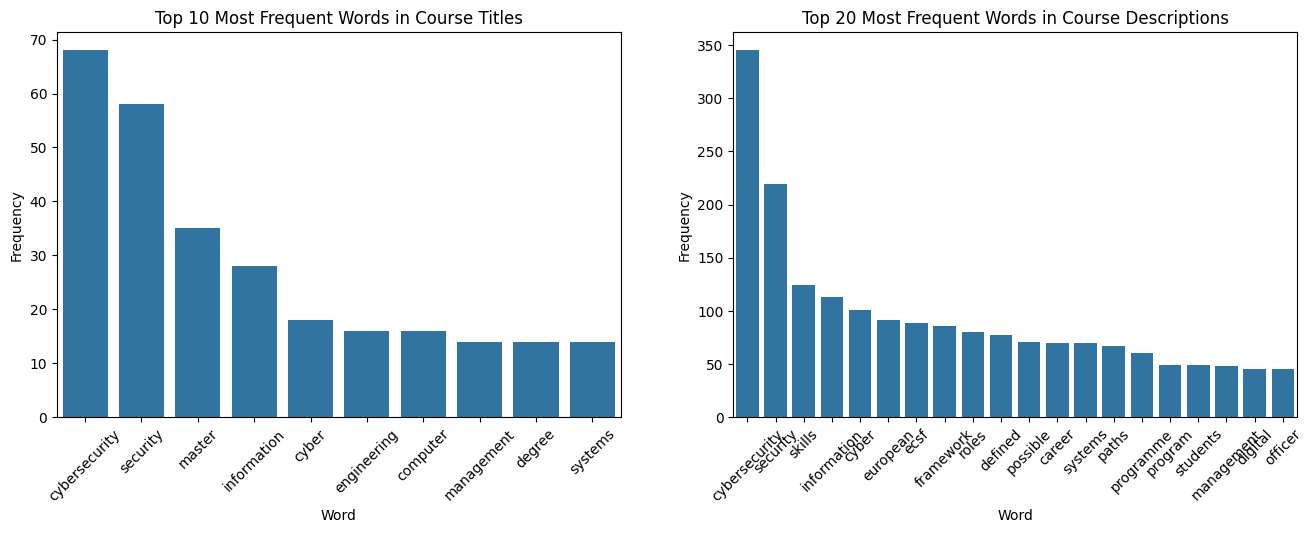

In [19]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Convert the common words lists into DataFrames for easy plotting
word_freq_title = pd.DataFrame(common_words_title, columns=['word', 'count'])
word_freq_desc = pd.DataFrame(common_words_desc, columns=['word', 'count'])

# Create a bar plot for the top words in titles
sns.barplot(x='word', y='count', data=word_freq_title, ax=axes[0])
axes[0].set_xlabel("Word")
axes[0].set_ylabel("Frequency")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title("Top 10 Most Frequent Words in Course Titles")

# Create a bar plot for the top words in descriptions
sns.barplot(x='word', y='count', data=word_freq_desc, ax=axes[1])
axes[1].set_xlabel("Word")
axes[1].set_ylabel("Frequency")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title("Top 20 Most Frequent Words in Course Descriptions")

#### Word Clouds
Word clouds offer a different visual perspective, where the size of each word is proportional to its frequency. This gives an immediate impression of the most prominent terms.

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

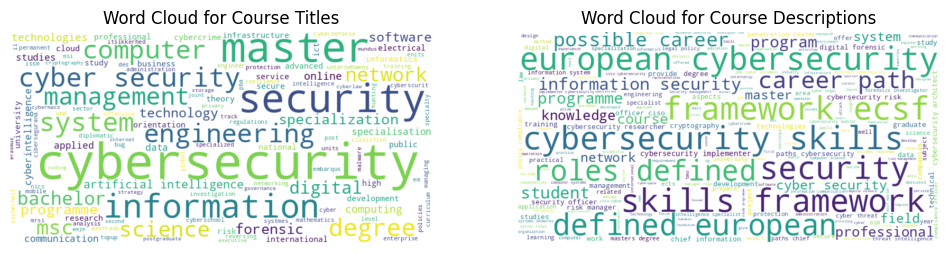

In [20]:
# Collect all words from titles and descriptions into separate list
all_words_title = [word for tokens in df['title_tokens'] for word in tokens]
all_words_desc = [word for tokens in df['desc_tokens'] for word in tokens]

# Generate a word cloud for titles
wordcloud_title = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_title))
wordcloud_desc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_desc))

# Create a figure with two subplots for the word clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(wordcloud_title, interpolation='bilinear')
axes[0].set_title('Word Cloud for Course Titles')
axes[0].axis("off")

#  Display the description word cloud
axes[1].imshow(wordcloud_desc, interpolation='bilinear')
axes[1].set_title('Word Cloud for Course Descriptions')
axes[1].axis("off")

#### N-gram Analysis (Bigrams)
While single words are informative, analyzing n-grams (sequences of N words) can reveal common phrases and concepts. We start by looking at bigrams (N=2) to find frequently co-occurring word pairs.

In [21]:
# Generate bigrams (pairs of consecutive words) from descriptions
bigrams = list(ngrams(all_words_desc, 2))
bigram_freq = Counter(bigrams).most_common(20) # Count the frequency of each bigram and get the top 20

# Convert the bigram frequencies into a DataFrame
bigram_df = pd.DataFrame(bigram_freq, columns=['bigram', 'count'])

# Print the most common bigrams
print("Most Common Bigrams:")
print(bigram_df)

Most Common Bigrams:
                          bigram  count
0      (european, cybersecurity)     83
1        (cybersecurity, skills)     82
2            (skills, framework)     82
3              (framework, ecsf)     82
4            (defined, european)     71
5               (roles, defined)     67
6             (possible, career)     64
7                (career, paths)     64
8        (information, security)     59
9              (cyber, security)     36
10  (cybersecurity, implementer)     35
11        (paths, cybersecurity)     31
12           (security, officer)     30
13               (officer, ciso)     30
14          (chief, information)     29
15   (cybersecurity, researcher)     25
16          (digital, forensics)     24
17         (cybersecurity, risk)     22
18    (cybersecurity, architect)     22
19               (risk, manager)     21


Even more profound insights into the themes and organization of the course material are provided by these most prevalent bigrams, which are word pairs that frequently occur together.

- **(information, security)** and **(cyber, security)** reinforce the idea that information security is the main topic
- **(computer, security)** and **(network, security)** suggest that different aspects of security are covered
- **(security, management)** and **(risk, management)** indicate that risk assessment and security governance are also major topics
- **(learning, outcomes)** and **(students, able)** suggest a strong emphasis on what students will achieve
- **(end, course)** likely refers to final objectives or outcomes stated at the conclusion of descriptions


With several bigrams focusing on cybersecurity, network security, risk management, and access control, security continues to be the most popular topic.
In addition to clearly defining what students will be able to do, course descriptions place a strong emphasis on student learning outcomes.
Data protection, operating systems, and machine learning are additional pertinent themes that demonstrate the variety of course subjects.

In [22]:
# Generate trigrams (sets of three consecutive words) from descriptions
trigrams = list(ngrams(all_words_desc, 3))
trigram_freq = Counter(trigrams).most_common(20) # Count the frequency of each trigram and get the top 20

# Convert the trigram frequencies into a DataFrame and orint the most common ones
trigram_df = pd.DataFrame(trigram_freq, columns=['trigram', 'count'])
print("Most Common Trigrams:")
print(trigram_df)

Most Common Trigrams:
                                        trigram  count
0             (european, cybersecurity, skills)     81
1            (cybersecurity, skills, framework)     81
2                     (skills, framework, ecsf)     80
3            (defined, european, cybersecurity)     71
4                    (roles, defined, european)     65
5                     (possible, career, paths)     62
6              (information, security, officer)     30
7                     (security, officer, ciso)     30
8                (career, paths, cybersecurity)     29
9                (chief, information, security)     29
10               (cybersecurity, risk, manager)     21
11                       (career, paths, chief)     17
12                  (paths, chief, information)     17
13                  (legal, policy, compliance)     15
14                (policy, compliance, officer)     15
15                (cyber, threat, intelligence)     15
16           (threat, intelligence, special

Trigrams we can provide an even richer understanding of course themes and structure.

Learning outcomes are clearly emphasized; descriptions usually list the goals that students will accomplish.
Data intelligence and security continue to be hot topics, supporting previous findings.

Other areas of emphasis include multidisciplinary learning and problem-solving.
In order to help students grasp expectations prior to enrollment, courses frequently outline prerequisites and syllabus specifics.


## Topic Modeling with TF-IDF and LDA
Firstly, we use **TF-IDF (Term Frequency-Inverse Document Frequency)** to represent course descriptions as numerical vectors. TF-IDF weights words based on their importance within a document relative to their frequency across all documents.

We then apply **Latent Dirichlet Allocation (LDA)**, a popular topic modeling technique, to discover underlying thematic topics within the course descriptions.

In [23]:
# Import TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer, considering only the top 100 features and removing English stopwords
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf.fit_transform(df['description'].dropna()) # Fit and transform the course descriptions (handling potential NaNs)
print(tfidf.get_feature_names_out()) # Print the names of the features (words) identified by TF-IDF

['administration' 'analysis' 'architect' 'areas' 'aspects' 'auditor'
 'bachelor' 'based' 'business' 'career' 'chief' 'ciso' 'communication'
 'companies' 'compliance' 'computer' 'course' 'courses' 'cryptography'
 'cyber' 'cybersecurity' 'data' 'defined' 'degree' 'design' 'development'
 'digital' 'ecsf' 'ects' 'education' 'engineering' 'european' 'experience'
 'field' 'forensics' 'framework' 'graduates' 'ict' 'implementer'
 'incident' 'industry' 'information' 'intelligence' 'investigator'
 'issues' 'knowledge' 'law' 'learning' 'legal' 'manage' 'management'
 'manager' 'master' 'methods' 'network' 'networks' 'offers' 'officer'
 'paths' 'penetration' 'policy' 'possible' 'practical' 'professional'
 'professionals' 'program' 'programme' 'project' 'projects' 'protection'
 'provide' 'provides' 'public' 'related' 'researcher' 'responder' 'risk'
 'roles' 'science' 'secure' 'security' 'skills' 'software' 'specialist'
 'specialization' 'students' 'studies' 'study' 'systems' 'technical'
 'technologi

In [24]:
# Import Latent Dirichlet Allocation for topic modeling
from sklearn.decomposition import LatentDirichletAllocation

# Initialize LDA with 5 topics and a fixed random state for reproducibility
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix) # Fit the LDA model to the TF-IDF matri

# Get the feature names (words) from the TF-IDF vectorizer
features = tfidf.get_feature_names_out()

# Iterate through each topic and print the top 10 words associated with it
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([features[i] for i in topic.argsort()[-10:]])

Topic 1:
['industry', 'cybersecurity', 'program', 'engineering', 'security', 'ict', 'information', 'aspects', 'professional', 'study']
Topic 2:
['studies', 'skills', 'law', 'industry', 'cybersecurity', 'learning', 'professional', 'training', 'education', 'administration']
Topic 3:
['defined', 'framework', 'roles', 'information', 'ecsf', 'european', 'skills', 'cyber', 'security', 'cybersecurity']
Topic 4:
['management', 'learning', 'information', 'secure', 'networks', 'network', 'program', 'computer', 'systems', 'security']
Topic 5:
['engineering', 'studies', 'technology', 'time', 'field', 'work', 'ict', 'bachelor', 'degree', 'experience']


##Name Entity Recognition

We use **spaCy**, an advanced NLP library, to perform **Named Entity Recognition (NER)**. NER helps us identify and classify named entities in the text, such as organizations (ORG), locations (GPE), dates (DATE), technologies, etc.

This can reveal specific tools, companies, or standards mentioned in the courses.

#### Install and Load spaCy
First, we install spaCy and download its small English model (`en_core_web_sm`).

In [25]:
# Install spaCy library for NLP tasks
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#### Process Descriptions and Visualize Entities
We load the spaCy model and process each course description. We extract the identified entities (text and label) and use `displacy` to visualize the entities in the first few descriptions for a quick check.

In [26]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Process each description to extract Named Entities (NER)
all_entities = []
for i, desc in enumerate(df["description"].dropna()):
    doc = nlp(desc)
    entities = [(ent.text, ent.label_) for ent in doc.ents] # Extract text and label
    all_entities.append(entities)
    if(i < 10):
      displacy.render(doc, style="ent", jupyter=True)  # Visualize entities for the first 10 descriptions in Jupyter

/usr/local/lib/python3.11/dist-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


#### **Inspect Extracted Entities**
Let's look at the entities extracted from the first 10 descriptions in a list format.

In [27]:
# Print the extracted entities for the first 10 descriptions
for i, entities in enumerate(all_entities[:10]):
    print(f"\nEntities {i+1}:", entities)


Entities 1: [('Palo Alto Networks', 'ORG'), ('Check Point Software Technologies', 'ORG'), ('First', 'ORDINAL'), ('year 2021/22', 'DATE'), ('September 2021', 'DATE'), ('Cybersecurity Researcher', 'ORG'), ('the European Cybersecurity Skills Framework (ECSF', 'ORG')]

Entities 2: [('the Cyber Security Management', 'ORG')]

Entities 3: [('Cybersecurity Implementer or', 'ORG'), ('Cybersecurity Architect or Penetration Tester', 'ORG'), ('the European Cybersecurity Skills Framework (ECSF', 'ORG')]

Entities 4: [('Cybersecurity', 'GPE'), ('Cyber Legal, Policy & Compliance', 'ORG'), ('Cybersecurity Architect', 'ORG'), ('the European Cybersecurity Skills Framework (ECSF', 'ORG')]

Entities 5: [('Cybersecurity', 'GPE'), ('International', 'ORG'), ('the United Nations Office on Drugs and Organized Crime', 'ORG'), ('UNODC', 'ORG')]

Entities 6: []

Entities 7: []

Entities 8: [('three-year', 'DATE'), ('Italian', 'NORP')]

Entities 9: [('Cyber Incident Responder', 'ORG'), ('Cyber Threat Intelligence

#### **Identify Unique Entity Types**
We can see all the different *types* of entities (like ORG, GPE, DATE, CARDINAL) that spaCy was able to recognize across all descriptions.

In [28]:
print('All entity types that spacy recognised from the course descriptions:')
unique_labels = set()  # Create an empty set to store unique labels
# Iterate through all extracted entities and add their labels to the set
for doc_entities in all_entities:
    for ent_text, ent_label in doc_entities:
        unique_labels.add(ent_label)

# Print the unique entity labels found
for label in unique_labels:
    print(label)

All entity types that spacy recognised from the course descriptions:
CARDINAL
GPE
FAC
PRODUCT
PERCENT
ORDINAL
NORP
TIME
WORK_OF_ART
LOC
PERSON
ORG
LANGUAGE
DATE


#### **Extract Specific Entity Types**
We can focus on specific entity types like Organizations (ORG) and Facilities (FAC) to see if particular institutions or labs are mentioned frequently.

In [30]:
# Create sets to store unique organization and facility names
organizations = set()
facilites = set()

# Iterate through all entities and add 'ORG' and 'FAC' entities to their respective sets
for entities in all_entities:
    for ent_text, ent_label in entities:
        if ent_label == 'ORG':
            organizations.add(ent_text)
        elif ent_label == 'FAC':
            facilites.add(ent_text)

# Print the extracted organizations
print('Organizations from the course descriptions:')
for org in organizations:
    print(org)

# Print the extracted facilities
print('\nFacilities from the course descriptions:')
for fac in facilites:
    print(fac)

Locations from the course descriptions:
Brno University of Technology
the European Cybersecurity Skills Framework - ECSF
Computer Engineering
European Cybersecurity Skills Framework
Ecix Group
the European Cybersecurity Competence Framework (ECSF
Cybersecurity Architect, Cybersecurity Implementer and Penetration Tester
ETCS
University of Tartu
Cybersecurity of the Sapienza University of Rome
Digital Service Development
TalTech
Cyber Incident Responder
PMS
Cybersecurity and Artificial Intelligence
Cybersecurity
Business and Data Analytics
KTH
Cybersecurity Architect or Cybersecurity Risk
Digital Identity, Communications
Cyber Threat Intelligence Specialist
The "Cybersecurity Management
Cybersecurity Architect, Cybersecurity Implementer
Problem Based Learning
Ethical Hacking
Cybersecurity Architect or
CLUSIL
the Inter-University Master in Cybersecurity (MUniCS)
Palo Alto Networks
Cybersecurity Architect or Penetration Tester
UGA
the Secure Information Systems Research Group
Network Secur

###Graph Analytics
We can try to represent the relationships between courses and entities as a graph. First, we create a DataFrame that lists each entity found, its label, and the index of the description it came from.

In [31]:
# Create a list to store data for the DataFrame
data = []

# Iterate through the extracted entities and format them for the DataFrame
for i, entities in enumerate(all_entities):
    for entity, label in entities:
        data.append({'index': i, 'text': entity, 'label': label})

# Create a pandas DataFrame from the list
sp_df = pd.DataFrame(data)
sp_df.reset_index(inplace=True)
sp_df.head() # Display the first few rows of the new DataFrame

,level_0,index,text,label
0,0,0,Palo Alto Networks,ORG
1,1,0,Check Point Software Technologies,ORG
2,2,0,First,ORDINAL
3,3,0,year 2021/22,DATE
4,4,0,September 2021,DATE


#### **Create Relationship DataFrame**
This step attempts to create a DataFrame for building a graph. It iterates through the entity DataFrame and re-processes the entity text with spaCy.

In [32]:
# Initialize empty lists to store relationship data
indexes = []
text_entities = []
entity_types = []
relationships = []

# Iterate through each row of the spaCy DataFrame
for idx, row in sp_df.iterrows():
  index = row['index'] # Get the original description inde
  text = row['text']  # Get the entity text
  entity_type = row['label']  # Get the entity label

  # Append data for the lists
  indexes.append(index)
  text_entities.append(text)
  entity_types.append(entity_type)

  # Re-process the entity text with spaCy to find potential relationships
  relationships.append([(ent.text, ent.ent_type_) for ent in nlp(text)]) # Get entities for the current text

In [33]:
# Create a new DataFrame from the lists, representing relationships
relationship_df = pd.DataFrame({ 'Index':indexes, 'Text': text_entities, 'Entity': entity_types, 'Relationship': relationships })
relationship_df.head() # Display the first few rows of the relationship DataFrame

,Index,Text,Entity,Relationship
0,0,Palo Alto Networks,ORG,"[(Palo, ORG), (Alto, ORG), (Networks, ORG)]"
1,0,Check Point Software Technologies,ORG,"[(Check, ORG), (Point, ORG), (Software, ORG), ..."
2,0,First,ORDINAL,"[(First, ORDINAL)]"
3,0,year 2021/22,DATE,"[(year, ), (2021/22, CARDINAL)]"
4,0,September 2021,DATE,"[(September, DATE), (2021, DATE)]"


#### **Create Graph with NetworkX**
Using the `networkx` library, we build a directed graph where nodes represent either a course description index or an entity type. An edge connects a description index to an entity type if that entity was found in that description.

In [34]:
# Import the networkx library for graph analysis
import networkx as nx

# Create an empty directed graph
graph = nx.DiGraph()

# Iterate through the relationship DataFrame to add edges to the graph
for _, row in relationship_df.iterrows():
  index = row['Index']
  text = row['Text']
  entity = row['Entity']
  relationship = row['Relationship']
  graph.add_edge(index, entity, relationship=relationship, desc=text)  # Add an edge from the description index to the entity type, with attributes


# Display the nodes and edges of the graph
print("Nodes:", graph.nodes())
print("Edges:")
for edge in graph.edges(data=True):
  print(edge)

Nodes: [0, 'ORG', 'ORDINAL', 'DATE', 1, 2, 3, 'GPE', 4, 7, 'NORP', 8, 9, 'CARDINAL', 'LANGUAGE', 10, 11, 'PERSON', 12, 13, 'WORK_OF_ART', 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 'FAC', 28, 29, 30, 'TIME', 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 'PRODUCT', 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 111, 'PERCENT', 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 'LOC']
Edges:
(0, 'ORG', {'relationship': [('the', 'ORG'), ('European', 'ORG'), ('Cybersecurity', 'ORG'), ('Skills', 'ORG'), ('Framework', 'ORG'), ('(', ''), ('ECSF', '')], 'desc': 'the European Cybersecurity Skills Framework (ECSF'})
(0, 'ORDINAL', {'relationship': [('First', 'ORDINAL')], 'desc': 'First'})
(0

### Analyze Connected Components
Connected components analysis helps find groups of nodes that are interconnected. We convert the graph to undirected for this analysis and look for components with more than one node.

In [35]:
# Perform connected component analysis on an undirected version of the graph
connected_components = list(nx.connected_components(graph.to_undirected()))

# Filter for connected components with more than one node
connected_components = [component for component in connected_components if len(component) > 1]

# Display the identified connected components
print("Connected components:")
for idx, component in enumerate(connected_components, start=1):
  print(f"Component {idx}: {component}")

Connected components:
Component 1: {0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 'ORG', 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 39, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 'TIME', 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 111, 'NORP', 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 'PRODUCT', 'LOC', 'GPE', 'WORK_OF_ART', 'DATE', 'PERSON', 'PERCENT', 'ORDINAL', 'FAC', 'LANGUAGE', 'CARDINAL'}


#### **Visualize the Graph**
We visualize the constructed graph using `networkx` and `matplotlib`. Due to the potential size and complexity, the resulting graph might be difficult to interpret directly but can reveal high-level connection patterns.

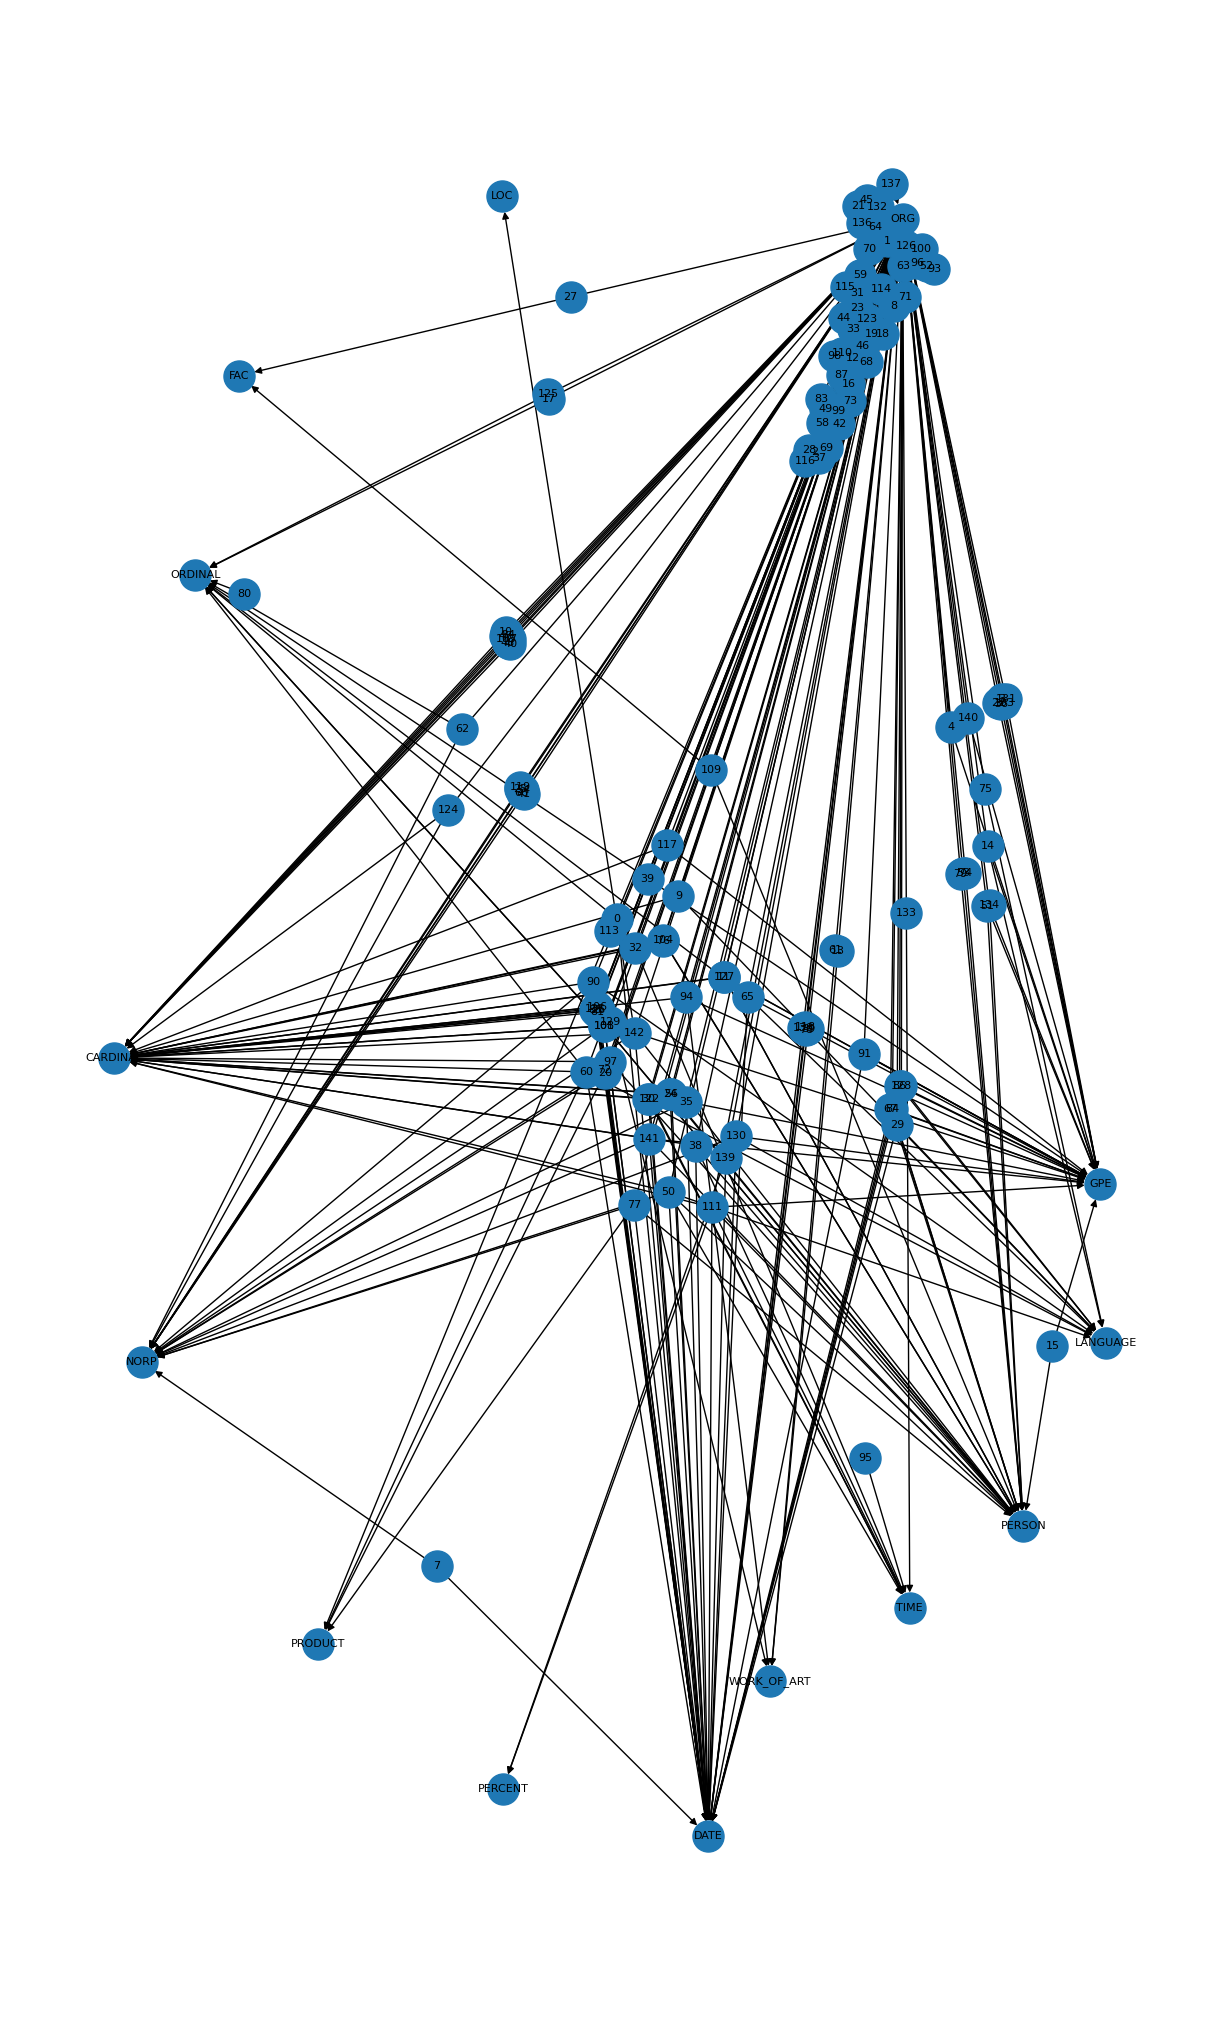

In [36]:
# Set the figure size for the visualization
plt.figure(figsize=(12, 20))

# Calculate node positions using the spring layout algorithm
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=8) # Draw the graph with labels, node sizes, and font size
plt.show()

### Skill Extraction

A key goal is to extract relevant cybersecurity skills mentioned in the course descriptions. We start with a predefined list of skills and aim to find matches within the text.

In [37]:
# Define an initial list of common cybersecurity skills
cyber_skills = [
    "network security", "cryptography", "penetration testing", "ethical hacking",
    "firewalls", "incident response", "risk assessment", "malware analysis",
    "information security", "cyber law", "digital forensics", "vulnerability assessment",
    "data protection", "security operations", "SIEM", "threat intelligence"
]

#### **Fuzzy String Matching**
To account for variations in phrasing (e.g., 'security of networks' vs. 'network security'), we use **fuzzy string matching** with the `fuzzywuzzy` library. This allows us to find approximate matches instead of only exact ones.

We also use spaCy to extract noun phrases, as skills are often expressed as nouns or noun phrases.

In [38]:
# Install the fuzzywuzzy library for fuzzy string matching (with speedup)
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.1 MB/s eta 0:00:00


In [39]:
# Import fuzzywuzzy for string matching
from fuzzywuzzy import fuzz
nlp = spacy.load("en_core_web_sm") # Load the spaCy model

In [40]:
# Define a function to extract noun phrases from text using spaCy
def extract_noun_phrases(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks]

In [41]:
# Define a function to match extracted phrases against a skill list using fuzzy matching
def match_skills(phrases, skill_list, threshold=85):
    matches = []
    for phrase in phrases:
        for skill in skill_list:
            if fuzz.partial_ratio(phrase.lower(), skill.lower()) >= threshold: # Check if the partial ratio similarity is above the threshold
                matches.append(skill)
    return list(set(matches))

In [42]:
# Define a function to orchestrate skill extraction from a description
def extract_skills_from_description(description, skill_list):
    noun_phrases = extract_noun_phrases(description)
    matched_skills = match_skills(noun_phrases, skill_list)
    return matched_skills

#### Apply Skill Extraction
We apply our skill extraction pipeline to each course description and store the results in a new 'extracted_skills' column.

In [46]:
# Apply the skill extraction function to each description in the DataFrame
df['extracted_skills'] = df['description'].apply(
    lambda x: extract_skills_from_description(x, cyber_skills)
)

In [47]:
# Display the course titles and their corresponding extracted skills for the first 10 row
df[['study_program_name', 'extracted_skills']].head(10)

,study_program_name,extracted_skills
0,Cybersecurity Engineering,"[security operations, information security, ne..."
1,Cyber Security Management,"[security operations, information security]"
2,Cybersecurity specialisation for Computer Scie...,[penetration testing]
3,MSc in Cybersecurity,"[cryptography, penetration testing, ethical ha..."
4,High Specialization Master in Forensic Computi...,[]
5,Management of Cybersecurity,[]
6,Secure Information Systems Bachelor,"[security operations, information security, ne..."
7,Computer Systems and Networks Security online,[information security]
8,Managing cybersecurity in the public sector,"[information security, threat intelligence, in..."
9,Software Systems Security,"[information security, incident response]"


Let's join the extracted skills and course title columns.

### Text Similarity Between Courses
We want to measure how similar courses are based on the skills they cover. We explore two methods: **Jaccard Similarity** and **Cosine Similarity** based on different vector representations.

#### **Jaccard Similarity based on Skills**
**Jaccard Similarity** measures the similarity between two sets by dividing the size of their intersection by the size of their union. It's suitable when we care about the *presence* or *absence* of skills rather than their frequency.

First, we convert the lists of extracted skills into strings, which allows us to use `CountVectorizer`.

In [48]:
# Convert the list of extracted skills into a single space-separated string for each course
df['skills_text'] = df['extracted_skills'].apply(lambda x: ' '.join(x))

- Next, we use `CountVectorizer` with `binary=True`. This creates a matrix where each row is a course and each column is a skill. A '1' indicates the skill is present in the course, and '0' indicates it's absent.

In [50]:
# Import CountVectorizer for creating a document-term matrix
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer to create binary vectors (presence/absence of skills)
vectorizer = CountVectorizer(binary=True)

# Fit and transform the skills text into a matrix
X = vectorizer.fit_transform(df['skills_text'])

# Convert the sparse matrix to a DataFrame for inspection
skill_vector_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=df['study_program_name'])

# Display the first few rows of the skill vector DataFrame
skill_vector_df.head()

,analysis,assessment,cryptography,cyber,data,digital,ethical,firewalls,forensics,hacking,...,network,operations,penetration,protection,response,risk,security,testing,threat,vulnerability
study_program_name,,,,,,,,,,,,,,,,,,,,,
Cybersecurity Engineering,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
Cyber Security Management,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
Cybersecurity specialisation for Computer Science & Engineering Masters degree,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
MSc in Cybersecurity,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
High Specialization Master in Forensic Computing and Cybercrime,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Now, we calculate the pairwise Jaccard similarity between all courses using their binary skill vectors. Scikit-learn's `pairwise_distances` provides Jaccard *distance*, so we convert it to similarity (1 - distance).

In [51]:
# Import pairwise_distances for calculating distances between vectors
from sklearn.metrics import pairwise_distances

In [52]:
# Compute pairwise Jaccard distances between skill vectors
jaccard_dist = pairwise_distances(X.toarray(), metric="jaccard")

# Convert Jaccard distance to Jaccard similarity (1 - distance)
jaccard_sim = 1 - jaccard_dist

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


- Finally, we display the Jaccard similarity matrix as a DataFrame for easy viewing.

In [53]:
# Create a DataFrame to store the Jaccard similarity matrix, using course titles as index and columns
jaccard_df = pd.DataFrame(
    jaccard_sim,
    index=df['study_program_name'],
    columns=df['study_program_name']
)

# Round the similarity scores for better readability
jaccard_df = jaccard_df.round(2)

# Display the first few rows of the Jaccard similarity DataFrame
jaccard_df.head()

study_program_name,Cybersecurity Engineering,Cyber Security Management,Cybersecurity specialisation for Computer Science & Engineering Masters degree,MSc in Cybersecurity,High Specialization Master in Forensic Computing and Cybercrime,Management of Cybersecurity,Secure Information Systems Bachelor,Computer Systems and Networks Security online,Managing cybersecurity in the public sector,Software Systems Security,...,Postgraduate studies Cybersecurity Management,Bachelor's Degree Programme in Business Information Technology (Cybersecurity Specialization),Digital Infrastructure and Cyber Security,National Security: Cyber​​security,Master of Research in Cybersecurity (Online),Computer Engineering and Science for Cybersecurity,Master of Science in Cyber Risk Strategy and Governance,"Cyber Security, Master of Science in Technology",Master in International Cybersecurity and Cyberintelligence,CyberMACS- Erasmus Mundus Joint Master’s Degree (EMJM) Programme in Applied Cybersecurity
study_program_name,,,,,,,,,,,,,,,,,,,,,
Cybersecurity Engineering,1.00,0.75,0.00,0.00,0.0,0.0,0.67,0.50,0.25,0.33,...,0.33,0.50,0.50,0.50,0.00,0.25,0.3,0.50,0.50,0.0
Cyber Security Management,0.75,1.00,0.00,0.00,0.0,0.0,0.50,0.67,0.29,0.40,...,0.40,0.33,0.33,0.33,0.00,0.12,0.2,0.38,0.33,0.0
Cybersecurity specialisation for Computer Science & Engineering Masters degree,0.00,0.00,1.00,0.29,0.0,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.0,0.00,0.00,0.0
MSc in Cybersecurity,0.00,0.00,0.29,1.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.22,0.00,0.00,0.00,0.29,0.00,0.0,0.00,0.00,0.0
High Specialization Master in Forensic Computing and Cybercrime,0.00,0.00,0.00,0.00,1.0,1.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,1.0


## Sentence Transformers for Semantic Similarity

**Sentence Transformers** provide a way to generate dense vector representations (embeddings) of sentences or entire documents that capture their *semantic* meaning. We use a pre-trained model to convert each course description into an embedding.

We can then calculate the **Cosine Similarity** between these embeddings, which measures the angle between vectors and gives a good indication of semantic similarity (values closer to 1 mean more similar).

#### Install Dependencies
We install `sentence-transformers` and its dependencies (`torch`).

In [54]:
# Install PyTorch and torchvision, which often required by sentence-transformers
!pip3 install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Install the sentence-transformers library
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_ext

#### **Generate Embeddings**
We load the `all-MiniLM-L6-v2` model (a fast and effective model) and use it to encode each description into a numerical vector.

In [57]:
# Import SentenceTransformer
from sentence_transformers import SentenceTransformer

# Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings (vector representations) for each course description
df['embedding'] = df['description'].apply(lambda x: model.encode(x))

In [58]:
# Display the first few generated embeddings
df['embedding'].head()

,embedding
0,"[0.008133715, -0.0031411233, -0.025041351, 0.0..."
1,"[-0.0016868738, 0.092382476, -0.07307896, 0.03..."
2,"[-0.0058970926, 0.035597883, -0.064209774, -0...."
3,"[-0.0031342297, 0.006976546, -0.06489285, -0.0..."
4,"[-0.016380643, -0.02225938, -0.08846137, -0.01..."


#### **Calculate Semantic Similarity**
We use the `model.similarity` function (which calculates cosine similarity) to find the pairwise similarity between all course embeddings.

In [60]:
# Get the embeddings as a list
embeddings = df['embedding'].to_list()

# Convert the list of NumPy arrays into a single NumPy array
embeddings = np.array(embeddings)

# Calculate the pairwise similarity between all embeddings using the model's utility function
similarities = model.similarity(embeddings, embeddings)
print(similarities)

tensor([[1.0000, 0.5383, 0.7950,  ..., 0.6410, 0.7256, 0.6798],
        [0.5383, 1.0000, 0.5865,  ..., 0.4214, 0.4632, 0.5122],
        [0.7950, 0.5865, 1.0000,  ..., 0.6762, 0.7084, 0.6893],
        ...,
        [0.6410, 0.4214, 0.6762,  ..., 1.0000, 0.6788, 0.6878],
        [0.7256, 0.4632, 0.7084,  ..., 0.6788, 1.0000, 0.7524],
        [0.6798, 0.5122, 0.6893,  ..., 0.6878, 0.7524, 1.0000]])


##RetVec
RETVec (Resilient and Efficient Text Vectorizer) is a lightweight, multilingual, and typo-resilient text vectorizer developed by Google Research. It's particularly useful for tasks like text classification and retrieval, especially in scenarios involving noisy or adversarial text inputs.

In [61]:
# Install the RETVec library
! pip install retvec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.6 MB/s eta 0:00:00


In [62]:
# Install RETVec and its common dependencies
!pip install retvec pandas scikit-learn tensorflow

In [ ]:
try:
    import retvec
except ImportError:
    !pip install retvec

try:
    import tensorflow_text
except ImportError:
    !pip install tensorflow-text

In [63]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # silence TF INFO messages
import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow.keras as keras
import numpy as np
from keras import layers
from keras.layers import TFSMLayer

# import the RETVec tokenizer layer
from retvec.tf import RETVecTokenizer

#### **Prepare Text for RETVec**
We combine titles and descriptions into a single text input for each course, as RETVec models typically process a single text field.

In [64]:
# Extract titles and descriptions as lists (ensuring they are strings)
titles = df["study_program_name"].astype(str).tolist()
descriptions = df["description"].astype(str).tolist()

# Combine titles and descriptions into a single text for each course
texts = [f"{title} {desc}" for title, desc in zip(titles, descriptions)]

#### **Load and Inspect RETVec Model**
We load a pre-saved RETVec model from Google Drive and inspect its signatures to understand its inputs and outputs.

In [67]:
import tensorflow as tf

model_path = "/content/drive/MyDrive/dslab/retvec_model"
loaded = tf.saved_model.load(model_path)

# Print all available signatures
print(loaded.signatures)

# Print detailed input/output info for serving_default
concrete_func = loaded.signatures['serving_default']
print("\nINPUTS:")
print(concrete_func.structured_input_signature)
print("\nOUTPUTS:")
print(concrete_func.structured_outputs)


_SignatureMap({'serving_default': <ConcreteFunction (*, args_0: TensorSpec(shape=(None, 16, 24), dtype=tf.float32, name='args_0')) -> Dict[['tokenizer', TensorSpec(shape=(None, 256), dtype=tf.float32, name='tokenizer')]] at 0x7C4916CCF3D0>})

INPUTS:
((), {'args_0': TensorSpec(shape=(None, 16, 24), dtype=tf.float32, name='args_0')})

OUTPUTS:
{'tokenizer': TensorSpec(shape=(None, 256), dtype=tf.float32, name='tokenizer')}


In [66]:
# Define a function to create a Keras model using the loaded RETVec layer
def create_retvec_model():

  # Define the input layer
  inputs = tf.keras.layers.Input(shape=(16, 24), dtype=tf.float32)

  model_path = '/content/drive/MyDrive/dslab/retvec_model'

  # Load the RETVec model as a Keras layer using TFSMLayer
  x = TFSMLayer(model_path, call_endpoint='serving_default')(inputs)
  print(x)

  # Add some dense layers for a downstream task (e.g., classification)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  outputs = layers.Dense(4, activation='sigmoid', name="output")(x)

  # Create and return the Keras model
  model = tf.keras.Model(inputs, outputs)
  return model

## Conclusion and Next Steps

This notebook lays the groundwork for analyzing course descriptions using NLP. We have explored the data, performed text preprocessing, analyzed word frequencies and n-grams, extracted named entities, experimented with topic modeling and various similarity measures, and performed clustering.

The insights can be used to:

- Suggest similar courses to students or curriculum planners.

- Extract key skills and knowledge areas covered in cybersecurity education.

- Identify potential gaps or overlaps in a curriculum

- Inform curriculum design based on identified topics and skills.
        
Future work can include:

- **Advanced Embeddings:** Exploring state-of-the-art models like BERT or domain-specific embeddings for better semantic understanding.

- **Clustering Refinement:** Experimenting with different numbers of clusters or clustering algorithms (e.g., hierarchical clustering).

- **Job Market Comparison:** Matching extracted skills and topics to requirements listed in job descriptions for cybersecurity roles.

- **Interactive Visualization:** Creating interactive dashboards to explore courses, topics, and similarities.
